# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
}
check_packages(d)

[OK] Your Python version is 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:35:11) 
[Clang 11.1.0 ]
[OK] numpy 1.21.5
[OK] matplotlib 3.5.1
[OK] sklearn 1.0.1


# Chapter 13: Going Deeper -- the Mechanics of PyTorch

**Big thanks and credit to Victor Fomin for creating and helping with the original draft of this section!**

## A short introduction to PyTorch-Ignite (Online Bonus Content)

In this section, we will explore PyTorch-Ignite, a library from the PyTorch ecosystem to help with training and evaluating neural networks in PyTorch flexibly and transparently. 


**Projects using PyTorch-Ignite**


There is a list of research papers with code, blog articles, tutorials, toolkits, and other projects that use PyTorch-Ignite. Notable projects include
- Medical Open Network for AI (MONAI) (https://monai.io) 
- Conversational AI with Transfer Learning (https://github.com/huggingface/transfer-learning-conv-ai) 
If you are interested in more projects using PyTorch-Ignite, please take a look at the detailed project list here: https://github.com/pytorch/ignite#projects-using-ignite



--- 

As we saw in previous sections, PyTorch training code usually contains two nested for-loops, one iterating over epochs and one iterating over dataset batches. In addition, we evaluate the model on the training and validation set to track the performance during training. In general, we also would like to create training checkpoints (to resume from one in case of an accidental failure); save the best model; use an experiment tracking system to visualize metrics, predictions, and so forth; and perform other basic tasks. These are the kinds of things that PyTorch-Ignite easily handles for the user while keeping PyTorch-like flexibility. In this sense, PyTorch-Ignite aims to simplify the model training process while promoting best practices. 

In a few words, PyTorch-Ignite provides 
- An extremely simple engine and event system (training loop abstraction)
- Out-of-the-box metrics to easily evaluate models
- Built-in handlers to compose training pipelines, save artifacts, and log parameters and metrics
- Distributed training support

Additional benefits of using PyTorch-Ignite are 
- Less code than pure PyTorch while ensuring maximum control and simplicity
- More modular code
In this section, we will build and train again a classifier for the MNIST dataset that we worked with in the previous section.


--- 

**Installing PyTorch-Ignite**

The code in the following subsections is based on PyTorch-Ignite version 0.4.6. PyTorch-Ignite can be installed via pip or conda, depending on your preference. For instance, the command for installing PyTorch ignite via pip is as follows:

    pip install pytorch-ignite

Below, you can find the command for installing PyTorch-Ignite via conda:
 
    conda install ignite -c pytorch

For the latest information on installing PyTorch-Ignite, please visit the official documentation at https://pytorch.org/ignite/#installation.

### Setting up the PyTorch model

First, to set the stage, we will repeat Steps 1, 2, and 3 from the section *Project two - classifying MNIST handwritten digits with minor restructuring*. We define the model, training, and validation datasets, optimizer, and loss function: 

In [1]:
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader 
 
from torchvision.datasets import MNIST 
from torchvision import transforms
 
 
image_path = './' 
torch.manual_seed(1) 
 
transform = transforms.Compose([ 
    transforms.ToTensor() 
]) 
 
 
mnist_train_dataset = MNIST( 
    root=image_path,  
    train=True,
    transform=transform,  
    download=True
) 
 
mnist_val_dataset = MNIST( 
    root=image_path,  
    train=False,  
    transform=transform,  
    download=False 
) 
 
batch_size = 64
train_loader = DataLoader( 
    mnist_train_dataset, batch_size, shuffle=True 
) 
 
val_loader = DataLoader( 
    mnist_val_dataset, batch_size, shuffle=False 
) 
 
 
def get_model(image_shape=(1, 28, 28), hidden_units=(32, 16)): 
    input_size = image_shape[0] * image_shape[1] * image_shape[2] 
    all_layers = [nn.Flatten()]
    for hidden_unit in hidden_units: 
        layer = nn.Linear(input_size, hidden_unit) 
        all_layers.append(layer) 
        all_layers.append(nn.ReLU()) 
        input_size = hidden_unit 
 
    all_layers.append(nn.Linear(hidden_units[-1], 10)) 
    all_layers.append(nn.Softmax(dim=1)) 
    model = nn.Sequential(*all_layers)
    return model 
 
 
device = "cuda" if torch.cuda.is_available() else "cpu"
 
model = get_model().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

As you can see, the code above only relies on PyTorch concepts we that we already introduced previously. Via the `get_model()` function, we define a reusable function to conveniently create a multilayer perceptron with a user-defined number of hidden layers, where each hidden layer is followed by a ReLU activation. The output layer is followed by a Softmax layer.

Note that the MNIST dataset does not have a pre-defined validation set split. For simplicity, we assigned the test dataset as the validation set for simplicity. However, if we use the validation set for model selection, it does not provide an unbiased estimate of the model's performance.

### Setting up training and validation engines with PyTorch-Ignite

When we are done setting up the most important parts, PyTorch-Ignite will handle all other boilerplate code. Next, we have to define a trainer engine by passing our model, optimizer, and loss function to the `ignite.engine.create_supervised_trainer()` function for creating a trainer object that is used to train supervised models conveniently (https://pytorch.org/ignite/generated/ignite.engine.create_supervised_trainer.html). In addition, we create an *evaluator* engine by passing PyTorch-Ignite’s out-of-the-box metrics and the model to the `ignite.engine.create_supervised_evaluator()` function (https://pytorch.org/ignite/generated/ignite.engine.create_supervised_evaluator.html#create-supervised-evaluator): 

In [2]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
 
 
trainer = create_supervised_trainer(
    model, optimizer, loss_fn, device=device
)
 
val_metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(loss_fn)
}
 
evaluator = create_supervised_evaluator(
    model, metrics=val_metrics, device=device
)

Both the `trainer` and `evaluator` objects are instances of the `Engine` class (https://pytorch.org/ignite/generated/ignite.engine.engine.Engine.html#ignite.engine.engine.Engine), which is one of the core components of PyTorch-Ignite. It is essentially an abstraction over the training or validation loops.

### Creating event handlers for logging and validation

We can customize the code further by adding all kinds of event handlers. `Engine` allows adding handlers for various events that are triggered during the run. When an event is triggered, the attached handlers (functions) are executed. Thus, for logging purposes, we add a function that will be executed at the end of every `log_interval` iteration:

In [3]:
# How many batches to wait before logging training status
log_interval = 100
 
@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss():
    e = trainer.state.epoch
    max_e = trainer.state.max_epochs
    i = trainer.state.iteration
    batch_loss = trainer.state.output
    print(f"Epoch[{e}/{max_e}], Iter[{i}] Loss: {batch_loss:.2f}")

Or, equivalently, without the decorator, we can attach the handler function to the trainer via an `add_event_handler()` call (https://pytorch.org/ignite/generated/ignite.engine.engine.Engine.html#ignite.engine.engine.Engine.add_event_handler).

Similar to creating an event handler for logging the training status that we created above, we can create an event handler for computing validation metrics after each epoch.
Via the following code, we will run the `evaluator` on the validation set data loader, `val_loader`, when an epoch completes:

In [4]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results():
    eval_state = evaluator.run(val_loader)
    metrics = eval_state.metrics
    e = trainer.state.epoch
    max_e = trainer.state.max_epochs
    acc = metrics['accuracy']
    avg_loss = metrics['loss']
    print(f"Validation Results - Epoch[{e}/{max_e}] Avg Accuracy: {acc:.2f} Avg Loss: {avg_loss:.2f}")

### Setting up training checkpoints and saving the best model

It is a common practice to save the trainer, model, optimizer, and other related objects during the training process. This allows us to resume the model training from the checkpoint in case of an accidental training interruption. We will use an out-of-the-box PyTorch-Ignite handler to set up a training checkpointing for each epoch:

In [5]:
from ignite.handlers import Checkpoint, DiskSaver
 
# We will save in the checkpoint the following:
to_save = {"model": model, "optimizer": optimizer, "trainer": trainer}
 
# We will save checkpoints to the local disk
output_path = "./output"
save_handler = DiskSaver(dirname=output_path, require_empty=False)
 
# Set up the handler:
checkpoint_handler = Checkpoint(
    to_save, save_handler, filename_prefix="training")

# Attach the handler to the trainer
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler)

Via the code above, we created a `Checkpoint` object (https://pytorch.org/ignite/generated/ignite.handlers.checkpoint.Checkpoint.html#ignite.handlers.checkpoint.Checkpoint), which allows us to save and load a model later.

Besides saving models to be able to resume an interrupted training run, we are primarily interested in saving the best model, for example, for making predictions later during the inference stage. We can then load a saved model via `torch.load` as explained in the section Saving and reloading the trained model in *Chapter 12, Parallelizing Neural Network Training with PyTorch*.

Usually, the best model is determined by the value of a validation metric. We will use the same handler, `Checkpoint`, to save the best model according to the highest validation accuracy:

In [6]:
# Store best model by validation accuracy
best_model_handler = Checkpoint(
    {"model": model},
    save_handler,
    filename_prefix="best",
    n_saved=1,
    score_name="accuracy",
    score_function=Checkpoint.get_default_score_fn("accuracy"),
)
 
evaluator.add_event_handler(Events.COMPLETED, best_model_handler)

### Setting up TensorBoard as an experiment tracking system

When running training with different configurations, another common practice is to use an experiment tracking system, for example, TensorBoard, to log parameters and metrics and to compare experiments. We will use the `TensorboardLogger` (https://pytorch.org/ignite/generated/ignite.contrib.handlers.tensorboard_logger.html#ignite.contrib.handlers.tensorboard_logger.TensorboardLogger) to log the trainer's loss and validation metrics:

In [7]:
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine
 
 
tb_logger = TensorboardLogger(log_dir=output_path)
 
# Attach handler to plot trainer's loss every 100 iterations
tb_logger.attach_output_handler(
    trainer,
    event_name=Events.ITERATION_COMPLETED(every=100),
    tag="training",
    output_transform=lambda loss: {"batch_loss": loss},
)
 
# Attach handler for plotting both evaluators' metrics after every epoch completes
tb_logger.attach_output_handler(
    evaluator,
    event_name=Events.EPOCH_COMPLETED,
    tag="validation",
    metric_names="all",
    global_step_transform=global_step_from_engine(trainer),
)

### Executing the PyTorch-Ignite model training code

The trainer is now set up and ready to be executed. Let’s train the model for five epochs via the `run()` method:

In [8]:
trainer.run(train_loader, max_epochs=5)

Epoch[1/5], Iter[100] Loss: 1.87
Epoch[1/5], Iter[200] Loss: 1.82
Epoch[1/5], Iter[300] Loss: 1.67
Epoch[1/5], Iter[400] Loss: 1.55
Epoch[1/5], Iter[500] Loss: 1.65
Epoch[1/5], Iter[600] Loss: 1.59
Epoch[1/5], Iter[700] Loss: 1.59
Epoch[1/5], Iter[800] Loss: 1.56
Epoch[1/5], Iter[900] Loss: 1.63
Validation Results - Epoch[1/5] Avg Accuracy: 0.91 Avg Loss: 1.56
Epoch[2/5], Iter[1000] Loss: 1.61
Epoch[2/5], Iter[1100] Loss: 1.56
Epoch[2/5], Iter[1200] Loss: 1.54
Epoch[2/5], Iter[1300] Loss: 1.54
Epoch[2/5], Iter[1400] Loss: 1.51
Epoch[2/5], Iter[1500] Loss: 1.53
Epoch[2/5], Iter[1600] Loss: 1.50
Epoch[2/5], Iter[1700] Loss: 1.50
Epoch[2/5], Iter[1800] Loss: 1.52
Validation Results - Epoch[2/5] Avg Accuracy: 0.92 Avg Loss: 1.54
Epoch[3/5], Iter[1900] Loss: 1.61
Epoch[3/5], Iter[2000] Loss: 1.60
Epoch[3/5], Iter[2100] Loss: 1.54
Epoch[3/5], Iter[2200] Loss: 1.51
Epoch[3/5], Iter[2300] Loss: 1.48
Epoch[3/5], Iter[2400] Loss: 1.56
Epoch[3/5], Iter[2500] Loss: 1.57
Epoch[3/5], Iter[2600] Loss

State:
	iteration: 4690
	epoch: 5
	epoch_length: 938
	max_epochs: 5
	output: 1.5042390823364258
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

We can start TensorBoard server with
    tensorboard --logdir='./output'
and display the dashboard in the browser:


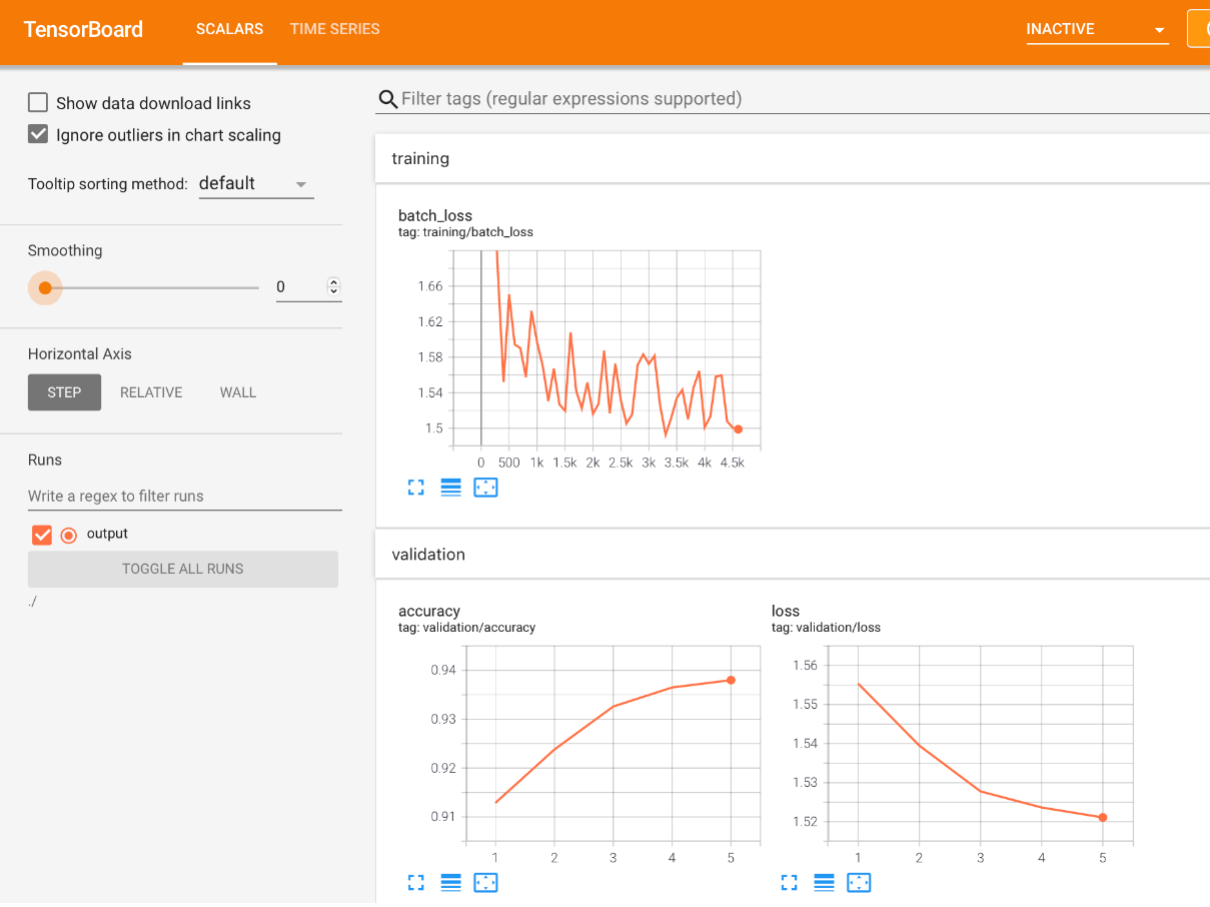

In [9]:
from IPython.display import Image
Image(filename='figures/ignite-01.png') 

---

**Next steps with PyTorch-Ignite**

To learn more about PyTorch-Ignite, please check out the official website containing and tutorials and how-to guides at https://pytorch-ignite.ai.

Among others, the website also includes a handy PyTorch-Ignite code-generator application (https://code-generator.pytorch-ignite.ai/) so you can start working on tasks without rewriting everything from scratch.

PyTorch-Ignite's code is available on GitHub: https://github.com/pytorch/ignite. The project is a community effort, and everyone is welcome to contribute and join the contributors’ community no matter your background and skills!


---

---

Readers may ignore the next cell.

In [10]:
! python ../.convert_notebook_to_script.py --input ch13_part4_ignite.ipynb --output ch13_part4_ignite.py

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook ch13_part4_ignite.ipynb to script
[NbConvertApp] Writing 13057 bytes to ch13_part4_ignite.py
